Imports, env variables, and API key

In [1]:
import requests
import tmdbsimple as tmdb
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

# Loading environment variables and API key
load_dotenv()

# Retrieve API key from environmental variable
API_KEY = os.getenv("TMDb_API_KEY")

# Backup: prompt user if API key is not set
if not API_KEY:
    print("API key not found in .env file.")
    API_KEY = input("Please enter your TMDb API key: ")

# Assign API key to tmdbsimple
tmdb.API_KEY = API_KEY

# Confirm API key is loaded
if API_KEY:
    print("API key loaded successfully!")
else:
    raise ValueError("TMDB API Key not found. Make sure it's set in the .env file.")

BASE_URL = "https://api.themoviedb.org/3"
WHOA_API_URL = "https://whoa.onrender.com/whoas/ordered/1-118"

API key loaded successfully!


Fetching TMDb Keanu movie credits and check the response status

In [2]:
def fetch_tmdb_data():
    url = f"{BASE_URL}/person/{6384}/movie_credits?api_key={API_KEY}"
    print(f"Requesting URL: {url}")
    response = requests.get(url)

    if response.status_code == 200:
        try:
            # Parsing JSON response
            movie_data = response.json()
            print("Request Successful!")

            # Extracting 'cast' information
            movies = movie_data.get('cast', [])

            # Creating a DataFrame with selected columns
            columns = ['movie_id', 'title', 'release_date', 'character', 'revenue']
            refined_movies = [
                {
                    'movie_id': movie.get('id'),  # Extract movie_id
                    'title': movie.get('title'),
                    'release_date': movie.get('release_date'),
                    'character': movie.get('character'),
                    'revenue': None  # Placeholder for now
                }
                for movie in movies
            ]

            tmdb_df = pd.DataFrame(refined_movies, columns=columns)
            print("TMDb DataFrame:")
            print(tmdb_df.head())
            return tmdb_df

        except requests.exceptions.JSONDecodeError:
            print("Error: Response could not be decoded as JSON")
            return pd.DataFrame()
    else:
        print(f"Error: {response.status_code} - {response.reason}")
        return pd.DataFrame()


Fetching "Whoa API" data

In [3]:
def fetch_whoa_data():
    headers = {"accept": "application/json"}
    response = requests.get(WHOA_API_URL, headers=headers)

    if response.status_code == 200:
        data = response.json()
        unique_movies = {movie['movie']: movie for movie in data}.values()
        df = pd.DataFrame(unique_movies)
        columns_to_keep = ['movie', 'year', 'release_date', 'character', 'total_whoas_in_movie']
        return df[columns_to_keep]
    else:
        print(f"Failed to fetch data from Whoa API. Status code: {response.status_code}")
        return pd.DataFrame()


Merging the data

In [4]:
# Function to merge TMDb and Whoa API data
def merge_data(tmdb_df, whoa_df):
    combined_df = pd.merge(
        whoa_df,
        tmdb_df,
        left_on=['movie'],
        right_on=['title'],
        how='left'
    )
    return combined_df

Fetching and updating the revenue "box office" information

In [5]:
def update_revenue_data(combined_df):
    revenues = []

    for index, row in combined_df.iterrows():
        movie_title = row['movie']
        movie_id = row.get('movie_id')

        if pd.isna(movie_title) or movie_id is None:
            revenues.append(None)
            print(f"Skipping movie: {movie_title} (No movie_id)")
            continue

        details_url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
        response = requests.get(details_url)

        if response.status_code == 200:
            movie_details = response.json()
            revenue = movie_details.get('revenue', None)
            revenues.append(revenue)
        else:
            print(f"Failed to fetch revenue for {movie_title} (ID: {movie_id})")
            revenues.append(None)
            
    combined_df['revenue'] = revenues
    return combined_df

Main execution

In [6]:
if __name__ == "__main__":
    print("Fetching TMDb data...")
    tmdb_df = fetch_tmdb_data()

    print("Fetching Whoa API data...")
    whoa_df = fetch_whoa_data()

    if not tmdb_df.empty and not whoa_df.empty:
        print("Merging data...")
        combined_df = merge_data(tmdb_df, whoa_df)

        print("Updating revenue data...")
        combined_df = update_revenue_data(combined_df)

        output_file = "keanu_combined_data_with_revenue.csv"
        combined_df.to_csv(output_file, index=False)
        print(f"Combined data saved to {output_file}")
    else:
        print("Error: One or more data sources are empty. Aborting.")


Fetching TMDb data...
Requesting URL: https://api.themoviedb.org/3/person/6384/movie_credits?api_key=93b29bf0b851209878217fccd1d8ca1a
Request Successful!
TMDb DataFrame:
   movie_id                 title release_date                     character  \
0       859    Dangerous Liaisons   1988-12-21  Le Chevalier Raphael Danceny   
1       468  My Own Private Idaho   1991-02-01                   Scott Favor   
2      1089           Point Break   1991-07-12                   Johnny Utah   
3       561           Constantine   2005-02-08              John Constantine   
4      1266          Street Kings   2008-04-10          Detective Tom Ludlow   

  revenue  
0    None  
1    None  
2    None  
3    None  
4    None  
Fetching Whoa API data...
Merging data...
Updating revenue data...
Failed to fetch revenue for Tune in Tomorrow (ID: nan)
Combined data saved to keanu_combined_data_with_revenue.csv


Creating a Pandas pivot table

In [7]:
# Creating the pivot table
pivot_table = combined_df.pivot_table(
    values = ['revenue', 'total_whoas_in_movie'],
    index = ['movie', 'year'],
    aggfunc = {'revenue': 'sum', 'total_whoas_in_movie': 'sum'}
)

pivot_table = pivot_table.sort_index(level = 'year')
pivot_table['revenue_numeric'] = pivot_table['revenue'].astype(float)
print(pivot_table[['revenue', 'revenue_numeric']]) 
# Reset index for easier plotting
pivot_table_reset = pivot_table.reset_index()


                                            revenue  revenue_numeric
movie                            year                               
Babes in Toyland                 1986  0.000000e+00     0.000000e+00
The Night Before                 1988  0.000000e+00     0.000000e+00
The Prince of Pennsylvania       1988  1.306400e+04     1.306400e+04
Bill & Ted's Excellent Adventure 1989  4.050000e+07     4.050000e+07
I Love You to Death              1990  0.000000e+00     0.000000e+00
Tune in Tomorrow                 1990  0.000000e+00     0.000000e+00
Bill & Ted's Bogus Journey       1991  3.800000e+07     3.800000e+07
Point Break                      1991  8.353196e+07     8.353196e+07
The Matrix                       1999  4.635174e+08     4.635174e+08
Sweet November                   2001  6.575423e+07     6.575423e+07
Knock Knock                      2015  6.341684e+06     6.341684e+06
The Neon Demon                   2016  3.400000e+06     3.400000e+06
Toy Story 4                      2

Using matplotlib to visualize the data and creating the bar chart

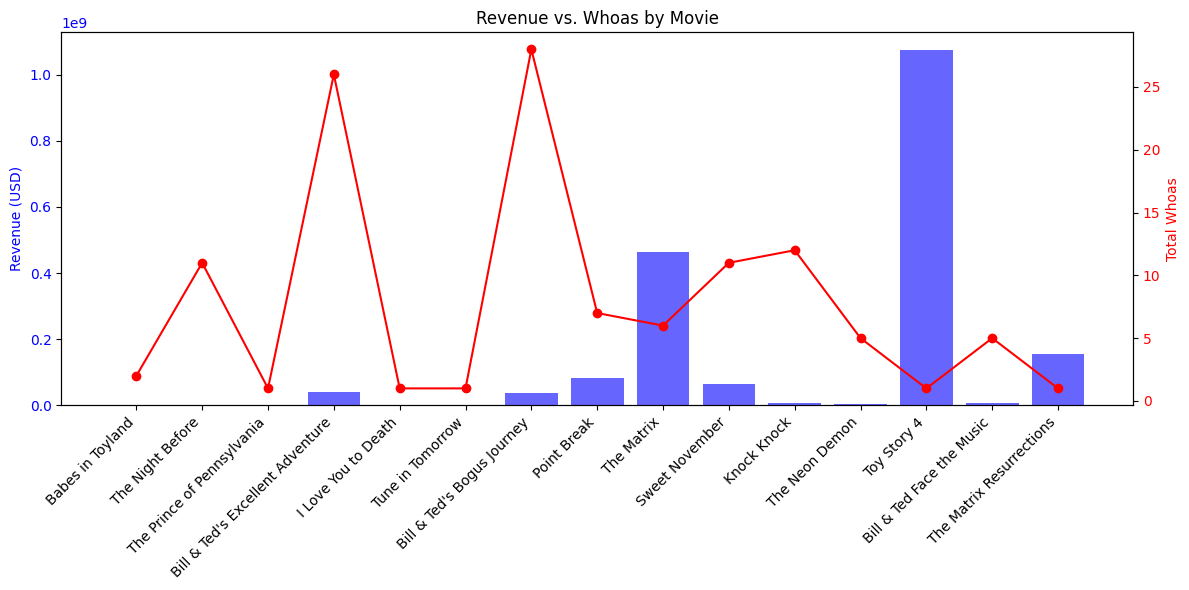

In [8]:
# Bar chart for revenue and whoas
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pivot_table_reset['movie'], pivot_table_reset['revenue'], 
        color='blue', alpha=0.6, label='Revenue')
ax1.set_ylabel('Revenue (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Whoas as line plot
ax2 = ax1.twinx()
ax2.plot(pivot_table_reset['movie'], pivot_table_reset['total_whoas_in_movie'], 
         color='red', marker='o', label='Total Whoas')
ax2.set_ylabel('Total Whoas', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Formatting
plt.title('Revenue vs. Whoas by Movie')
ax1.set_xticks(range(len(pivot_table_reset['movie'])))
ax1.set_xticklabels(pivot_table_reset['movie'], rotation=45, ha='right', fontsize=10)
fig.tight_layout()
plt.show()


Creating the scatter plot

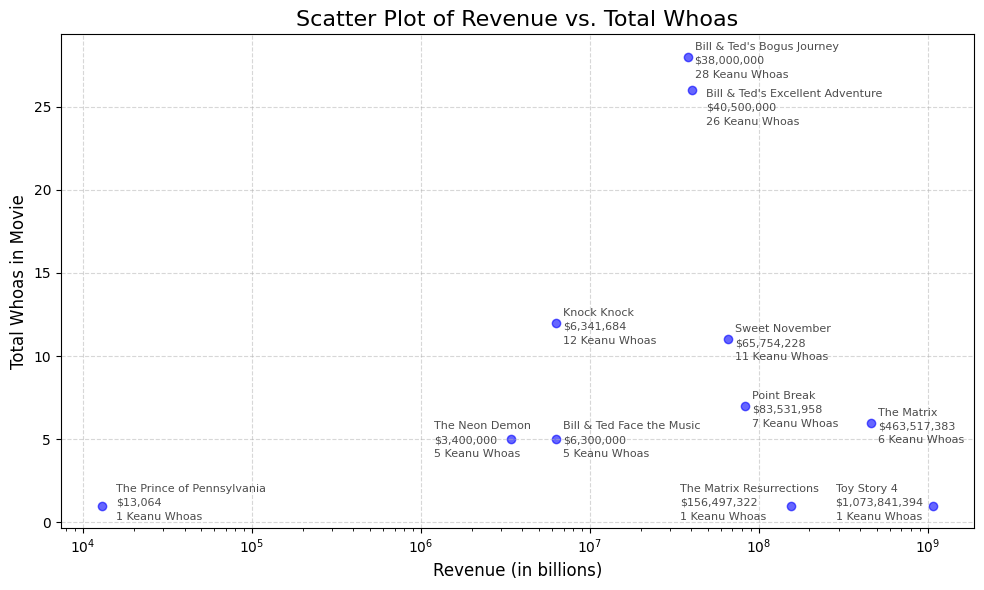

In [9]:
# Scatter plot with movie titles, revenue, and "Whoas" annotated
plt.figure(figsize=(10, 6))

# Scatter plot with numerical revenue
plt.scatter(pivot_table['revenue_numeric'], pivot_table['total_whoas_in_movie'], color='blue', alpha=0.6)

# Adding labels and a title
plt.title('Scatter Plot of Revenue vs. Total Whoas', fontsize=16)
plt.xlabel('Revenue (in billions)', fontsize=12)
plt.ylabel('Total Whoas in Movie', fontsize=12)

# Annotating each point with the movie name, revenue, and "Whoas"
for i, row in pivot_table.iterrows():
    movie_name = row.name[0]
    revenue = f"${row['revenue_numeric']:,.0f}"  # Formatting revenue as currency
    whoas = f"{int(row['total_whoas_in_movie'])} Keanu Whoas"  # Formatting "Whoas" count as an integer
    offset = (5, 5)  # Default offset for movie title

    # Offsetting a few of the titles
    if movie_name == "The Neon Demon":
        offset = (-55, 7)
    elif movie_name == "Bill & Ted Face the Music":
        offset = (5, 7)
    elif movie_name == "Bill & Ted's Excellent Adventure":
        offset = (10, -5)
    elif movie_name == "The Matrix Resurrections":
        offset = (-80, 10)
    elif movie_name == "Toy Story 4":
        offset = (-70, 10)
    elif movie_name == "The Prince of Pennsylvania":
        offset = (10, 10)

    # Annotate movie title
    plt.annotate(
        movie_name,  # Movie name
        (row['revenue_numeric'], row['total_whoas_in_movie']),
        fontsize=8,
        alpha=0.7,
        xytext=offset,  # Title offset
        textcoords='offset points'
    )

    # Annotate box office revenue underneath the title
    plt.annotate(
        revenue,  # Box office revenue
        (row['revenue_numeric'], row['total_whoas_in_movie']),
        fontsize=8,
        alpha=0.7,
        xytext=(offset[0], offset[1] - 10),  # Move revenue below the title
        textcoords='offset points'
    )

    # Annotate "Whoas" count underneath the revenue
    plt.annotate(
        whoas,  # Whoas count
        (row['revenue_numeric'], row['total_whoas_in_movie']),
        fontsize=8,
        alpha=0.7,
        xytext=(offset[0], offset[1] - 20),  # Move "Whoas" below the revenue
        textcoords='offset points'
    )

plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting axis scale if necessary
plt.xscale('log')  
plt.tight_layout()
plt.show()


Creating a Histogram

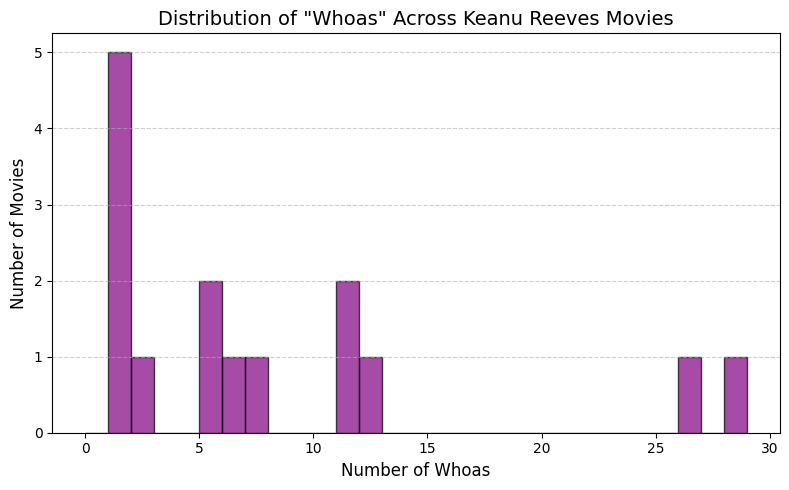

In [10]:
# Histogram of Whoas per Movie
plt.figure(figsize=(8, 5))

# Plotting the histogram
plt.hist(pivot_table['total_whoas_in_movie'], bins=range(0, int(pivot_table['total_whoas_in_movie'].max()) + 2), 
         color='purple', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.title('Distribution of "Whoas" Across Keanu Reeves Movies', fontsize=14)
plt.xlabel('Number of Whoas', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
